![logo](./img/LogoLine_horizon_C3S.png)

## Tutorial on comparing CARRA and ERA5 data 2m temperature 

CARRA (Copernicus Arctic Regional Reanalysis) and ERA5 (ECMWF's flagship global reanalysis) data can be found in the [CDS (Copernicus Climate Data Store)](https://cds.climate.copernicus.eu/#!/home).

The available 4 (single, height, pressure and model levels) CARRA entries are at [](https://cds.climate.copernicus.eu/cdsapp#!/search?text=CARRA). Here the CARRA single level entry is selected for the 2m temperature (also to limit the data amount). Practical details of the CARRA dataset are available in [the documentation](https://confluence.ecmwf.int/x/K0s7E).

The complete ERA5 entry is availble at [](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=overview).

The objective of the tutorial is to demonstrate how to download CARRA and ERA5 data and how to inter-compare them on the CARRA domain. CARRA is a high resolution (2.5 km) regional reanalysis which gives added details compared to the ERA5 global reanalysis. These details can be visualised by comparing the plots of CARRA and ERA5 data and particularly when the differences of the two dataset are plotted. 

Note that you need to create an account and accept the terms and conditions for all datasets that you want to use.


### Fetching CARRA and ERA5 data
The source code will download a specific month. By specifying the start and end date below one can easily download longer periods. We are selecting 2m temperature, which is in the single level CDS entry. 
Here, we download the 3-hourly analysis time steps and the data will be stored in a specified file.
For more details on ERA5 data download please see the [CDS tutorials in this link](https://github.com/ecmwf-projects/copernicus-training-c3s).


![logo](./img/climatology_banner.png)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>
      To run the notebooks in the cloud environment click on the icons for "binder" or "kaggle" or "colab" in the menubar below.<br><br>
      <div>
        <a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
          <img src="https://mybinder.org/badge.svg" alt="Binder">
        </a>
        <a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
          <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Kaggle">
        </a>
        <a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
          <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab">
        </a>
      </div>
    </th>
  </tr>
</table>


### Setup the CDSAPI and your credentials

*You may not need this subsection, it has been inserted here as an example of a tutorial/guide on how to access and explore data from the C3S Climate Data Store.*

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credentials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [3]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Import libraries

To run the code in this tutorial please install any missing packages here.

In [4]:
import os
import cdsapi
import warnings
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
#package to interpolate ERA5 data to the CARRA grid
import xesmf as xe


warnings.filterwarnings('ignore') #turn off some warnings

/usr/local/apps/esmf/8.8.0/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


### Define CDS data request details

For this tutorial we just request one month, March 2024. Note that we define a sub-domain to use for the ERA5 request.

In [5]:
# Here one specifies the domain, year and period to download

yearStart = 2024 #first year to download
yearEnd   = 2024 #last year to download
monthStart =  3 # first month to download
monthEnd   =  3 #last month to download
days = [str(i).zfill(2) for i in range(1,31)] # the list of days to download. Adapt day number for other months
domain = 'west_domain' # the domain to select. Use "east_domain" for the CARRA-East domain
period="202403" # the period to plot

#Below a polygon to limit the area downloaded from ERA5, otherwise it will download the whole world
area_for_era5 = [90, -110, 55, 40] #WEST domain polygon, format: North,West,South,East corners
#area_for_era5 = [85,0,60,50]: EAST domain polygon

### Specify data directory

In [6]:
# Directory to store data
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)
  
fCARRA = os.path.join(DATADIR,"carra_T2m_an_"+period+".grb")
fERA5 = os.path.join(DATADIR,"era5_T2m_an_"+period+".grb")

### Define helper functions to formulate the CDS data request

The functions below allow repeated CDS API requests to be made in case multiple requests are required to retrieve high volumes of data. In this case we are only requesting one month.

In [7]:
#Call the CDS client
c = cdsapi.Client(url=cdsapi_url,key=cdsapi_key)

# define a helper function to download the data
# Note that the time is hardcoded since we are selecting
# all possible available times. 
def fetch_month_carra(month, year, days, domain, fout):
    c.retrieve(
        'reanalysis-carra-single-levels',
        {
            'format': 'grib',
            'domain': domain ,
            'level_type': 'surface_or_atmosphere',
            'variable': '2m_temperature',
            'product_type': 'analysis',
            'year': year,
            'month': month,
            'day': days,
            'time': [
                '00:00', '03:00', '06:00',
                '09:00', '12:00', '15:00',
                '18:00', '21:00',
            ],
        },
        fout)
    
# Help function to download ERA5 data
def fetch_month_era5(month, year, days, area, fout):
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': str(year),
        'month': str(month).zfill(2),
        'day': days,
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': area,
        'format': 'grib',
    },
     fout)

2025-07-14 14:58:27,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


### Request the CARRA-West data

The loops below may be useful if you are requesting a large volume of data, in this case one one month is being requested.

In [8]:
# Loop through the period selected (in this example only 2024 03 is requested)
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(1,13)):
        if year == yearStart and month < monthStart:
            # Before the start date.
            continue
        if year == yearEnd and month > monthEnd:
            # After end date.
            break

        print ("CARRA data will be fetched for ", year, month)
        print("This will take a few minutes, depending on the data size (here ~621 MB for west, ~357 MB for east case)")
        fetch_month_carra(month, year, days, domain,fCARRA)

CARRA data will be fetched for  2024 3
This will take a few minutes, depending on the data size (here ~621 MB for west, ~357 MB for east case)


2025-07-14 14:58:33,075 INFO Request ID is 6dfc5d9b-48bd-4b66-919d-251dd80a8f3a
2025-07-14 14:58:33,112 INFO status has been updated to accepted
2025-07-14 14:58:41,424 INFO status has been updated to running
2025-07-14 14:59:05,803 INFO status has been updated to successful


1028b653c4aa08df03f85af49c8e4f4b.grib:   0%|          | 0.00/621M [00:00<?, ?B/s]

### Request the ERA5 data

In [10]:
# Loop through the period selected
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(1,13)):
        if year == yearStart and month < monthStart:
            # Before the start date.
            continue
        if year == yearEnd and month > monthEnd:
            # After end date.
            break

        print ("ERA5 data will be fetched for ", year, month)
        print("This will take a few minutes, depending on the data size (here ~39 MB for west area)")
        fetch_month_era5(month, year, days, area_for_era5,fERA5)

ERA5 data will be fetched for  2024 3
This will take a few minutes, depending on the data size (here ~39 MB for west area)


2025-07-14 15:00:05,634 INFO Request ID is 11552b6e-b214-4b33-a429-af13174ae83b
2025-07-14 15:00:05,653 INFO status has been updated to accepted
2025-07-14 15:00:13,982 INFO status has been updated to running
2025-07-14 15:00:19,078 INFO status has been updated to successful


e0c7e74829e167c9e5390f598e4266ba.grib:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

# Plotting the CARRA and ERA5 data

## Interpolate data to a common grid
Before plotting the two data sets we want to have them on the same grid. For this we interpolate ERA5 to the CARRA (CARRA-West) grid. Below we use [xesmf](https://xesmf.readthedocs.io/en/stable/). The interpolation/projection can also be done using the [pyresample](https://pyresample.readthedocs.io/en/latest/howtos/swath.html) library, or [CDO](https://code.mpimet.mpg.de/projects/cdo).

Inspect the ERA5 datacube.

In [11]:
ERA5  = xr.open_dataset(fERA5)
ERA5

<xarray.Dataset> Size: 81MB
Dimensions:     (time: 240, latitude: 141, longitude: 601)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 2kB 2024-03-01 ... 2024-03-30T21:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 90.0 89.75 89.5 89.25 ... 55.5 55.25 55.0
  * longitude   (longitude) float64 5kB -110.0 -109.8 -109.5 ... 39.5 39.75 40.0
    valid_time  (time) datetime64[ns] 2kB ...
Data variables:
    t2m         (time, latitude, longitude) float32 81MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-14T15:00 GRIB to CDM+CF via cfgrib-0.9.1...

Inspect the CARRA datacube.

In [12]:
CARRA  = xr.open_dataset(fCARRA)
CARRA

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 240, y: 1269, x: 1069)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2024-03-01 ... 2024-03-30T21...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 11MB ...
    longitude          (y, x) float64 11MB ...
    valid_time         (time) datetime64[ns] 2kB ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (time, y, x) float32 1GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2025-07-14T15:00 GRIB to CDM+CF via cfgrib-0.9.1...

We remove some additional coordinates in the datasets, to ease the regridding operation.

In [13]:
ERA5 = ERA5.drop_vars(['number', 'step', 'valid_time', 'surface'])
CARRA = CARRA.drop_vars(['step', 'valid_time', 'heightAboveGround'])

Now use xesmf bilinear interpolation to construct a regridder object and apply it to the ERA5 data.

In [14]:
# Create regridder using xesmf bilinear interpolation
regridder = xe.Regridder(ERA5, CARRA, "bilinear")
# Regrid the data
print("regridding the ERA5 data")
ERA5_CARRA = regridder(ERA5)
print("done")

regridding the ERA5 data
done


Check the format of the output and save it.

In [15]:
ERA5_CARRA
fERA5_CARRA_grid = os.path.join(DATADIR,"era5_t2m_"+period+"_CARRA_grid.nc")
ERA5_CARRA.to_netcdf(fERA5_CARRA_grid)

## Plotting the data
Compute the mean 2m temperature over the whole month.
First we open the data sets using xarray and then calculate the mean over the whole month, and deal with the units.


In [16]:
# Open the data sets to plot using xarray

import xarray as xr

# Open Datasets
CARRA = xr.open_dataset(fCARRA)
CARRA = CARRA.drop_vars(['step', 'valid_time', 'heightAboveGround'])
ERA5  = xr.open_dataset(fERA5_CARRA_grid)

# Compute monthly mean
print("Computing the mean for CARRA and ERA5...")
CARRA_mean = CARRA.mean("time", keep_attrs=True)
ERA5_mean = ERA5.mean("time", keep_attrs=True)
print("Done.")

# Change longitudes from 0-360 to -180 to 180, needed for the plotting
CARRA_mean = CARRA_mean.assign_coords(longitude=(((CARRA_mean.longitude + 180) % 360) - 180))
ERA5_mean = ERA5_mean.assign_coords(longitude=CARRA_mean.longitude)

# Change unit from K to C and add the unit to the attributes
CARRA_mean_C = CARRA_mean - 273.15
CARRA_mean_C = CARRA_mean_C.assign_attrs(CARRA_mean.attrs)
CARRA_mean_C.attrs['units'] = 'deg C'
ERA5_mean_C = ERA5_mean - 273.15
ERA5_mean_C = ERA5_mean_C.assign_attrs(ERA5_mean.attrs)
ERA5_mean_C.attrs['units'] = 'deg C'

Computing the mean for CARRA and ERA5...
Done.


### Plot for CARRA

We fix the range of each of the separate CARRA and ERA5 plots to -30 to 30 so that they can be compared directly. 

The plot below shows the CARRA 2m temperature monhly mean (March 2024) values for the CARRA-West domain. 

Plotting CARRA mean surface temperature


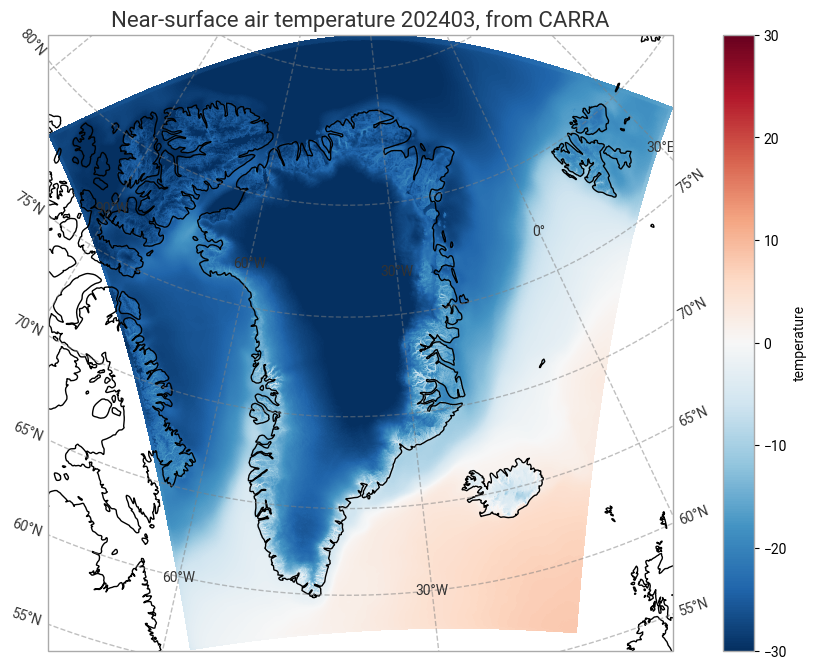

In [21]:
print("Plotting CARRA mean surface temperature")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(CARRA_mean_C.longitude, CARRA_mean_C.latitude,CARRA_mean_C.t2m,
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-30, vmax=30)

# Set the figure title
ax.set_title('Near-surface air temperature '+period+', from CARRA', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

### Plot for ERA5

The plot shows ERA5 2m temperature monthly mean (March 2024) values on the CARRA-West domain. 

Plotting ERA5 mean surface temperature


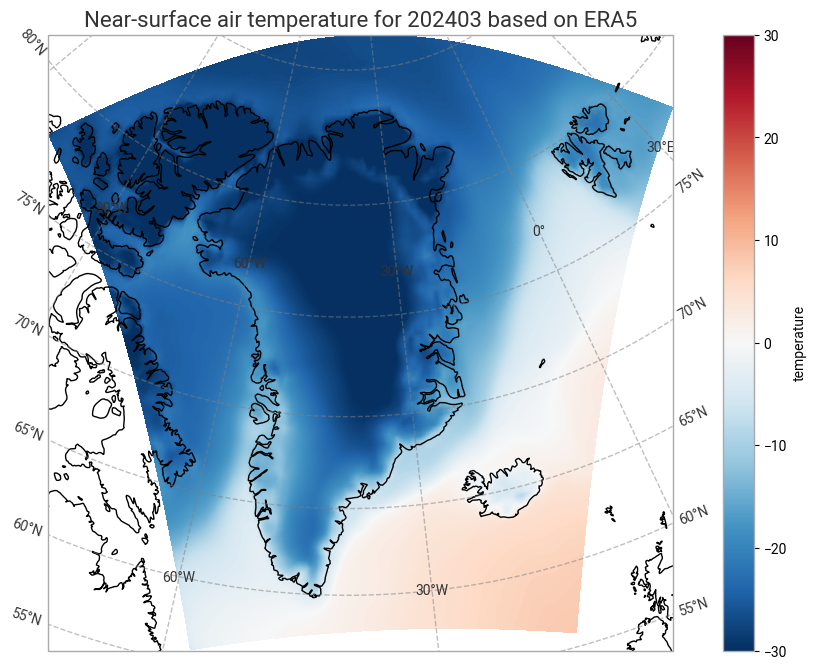

In [22]:

print("Plotting ERA5 mean surface temperature")

# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_mean_C.longitude, ERA5_mean_C.latitude, ERA5_mean_C.t2m, 
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-30, vmax=30)

# Set the figure title
ax.set_title('Near-surface air temperature for '+period+' based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

### Plot the difference between CARRA and ERA5
Note that the differences are computed in the plotting command itself. Here we plot the difference with a range of -10 to 10.

The plot shows the 2m monthly mean (March 2024) 2m temperature difference between CARRA and ERA5 over the CARRA-West domain.

Plot the difference CARRA - ERA5


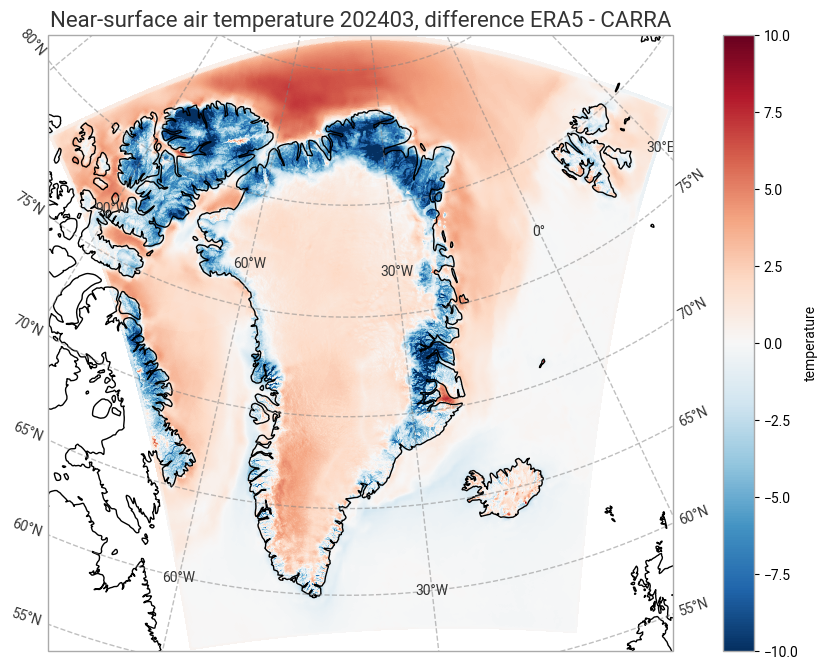

In [23]:
print("Plot the difference CARRA - ERA5")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data, the differences are computed directly in the line below.
im = plt.pcolormesh(CARRA_mean_C.longitude, CARRA_mean_C.latitude, ERA5_mean_C.t2m - CARRA_mean_C.t2m,
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-10, vmax=10)

# Set the figure title
ax.set_title('Near-surface air temperature '+period+', difference ERA5 - CARRA', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

### Reading the plots

Note the differences visible between CARRA and ERA5, especially over coastal areas and over complex orography where the high resolution CARRA data can provide additional information compared to ERA5, such as the significantly lower temperatures at higher elevations near the coasts.

The differences at the Northern ocean areas likely come from the better description of sea-ice characteristics by CARRA. 

The differences are much easier to see in the difference plot above, however they can also be recognised in the individual plots as finer detail in the CARRA plot.